In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from torch import nn
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [2]:
#分别得到坐标值和feature
#print(set(data['Yaw_Angle'].values),len(data['Yaw_Angle'].values))
data = pd.read_csv('处理数据/标准化数据.csv')
position_global = np.array(data[['Global_X','Global_Y']])
position_local =  np.array(data[['Local_X','Local_Y']])
#vehicle_feature = np.array(data.drop(['Vehicle_ID','Frame_ID','Total_Frames','Global_Time','Global_X','Global_Y','Location_peachtree'],
        #                            axis=1))
vehicle_feature = np.array(data[['Local_X','Local_Y',
                                 'v_length','v_Width','v_Class_1','v_Class_2',
                                 'v_Class_3','v_Vel','v_Acc','Preceding','Following',
                                 'Direction_1',
                                 'Direction_2','Direction_3','Direction_4','Movement_1','Movement_2','Movement_3'
                              ]])

vehicle_label = np.zeros_like(position_local)
vehicle_label[:-1],vehicle_label[-1] = position_local[1:],position_local[0]
#vehicle_label = position_local
vehicle_feature = vehicle_feature.astype(np.float32)
vehicle_label = vehicle_label.astype(np.float32)

split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)
train_x,val_test_x = vehicle_feature[:int(len(vehicle_feature)*split_frac)],vehicle_feature[int(len(vehicle_feature)*split_frac):]
val_x,test_x = val_test_x[:len(val_test_x)//2],val_test_x[len(val_test_x)//2:]

train_y,val_test_y = vehicle_label[:int(len(vehicle_label)*split_frac)],vehicle_label[int(len(vehicle_label)*split_frac):]
val_y,test_y = val_test_y[:len(val_test_y)//2],val_test_y[len(val_test_y)//2:]


import torch
from torch.utils.data import TensorDataset, DataLoader
 
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))


# dataloaders
batch_size = 512

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

#iters = iter(train_loader)
#x, y = next(iters)
#print(x,y)
#得到车辆数
vehicle_id = np.array(data['Vehicle_ID'])
print('总采样数为:',len(vehicle_feature))
print('总车辆数为:',len(np.unique(vehicle_id)))

总采样数为: 1676606
总车辆数为: 1545


In [4]:
data1 = pd.read_csv('data/NGSIM_Peachtree_Vehicle_Trajectories.csv')
#data2 = pd.read_csv('data/NGSIM__Lankershim_Vehicle_Trajectories.csv')
data3  = pd.read_csv('data/Next_Generation_Simulation__NGSIM__Vehicle_Trajectories_and_Supporting_Data.csv')

data_ = pd.concat([data1,data3],axis=0)
quant_features = ['Local_X','Local_Y','Global_X','Global_Y']
scaled_features = {}
print('start..')
for each in quant_features:
    mean, std = data_[each].mean(), data_[each].max()-data_[each].min()
    scaled_features[each] = [mean, std]
    data_.loc[:, each] = (data_[each] - mean)/std
mean_x, std_x = scaled_features['Local_X']
mean_y, std_y = scaled_features['Local_Y']
print(mean_x, std_x)
print(mean_y, std_y)

start..
0.2436986727949202 486.509
927.7015568869493 2113.03


In [5]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(LSTM, self).__init__()
        
        self.hidden_dim=hidden_dim
        self.n_layers = n_layers
        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers,dropout=0, batch_first=True)
        
        # last, fully-connected layer
        self.fc1 = nn.Linear(hidden_dim,hidden_dim*2)
        self.fc = nn.Linear(hidden_dim*2, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.lstm(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.contiguous().view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc1(r_out)
        output = self.fc(output)
        output = output.view(batch_size,-1,2)
        output = output[:,-1]
        
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if train_on_gpu:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        return hidden

if torch.cuda.is_available():
    train_on_gpu = True
else:
    train_on_gpu = False

In [6]:
def train(net,epochs,train_loader,valid_loader,clip,print_every,lr = 0.0002):
    # train for some number of epochs
    # loss and optimization functions

    loss_min = np.inf
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    counter = 0
    losses_train =[]
    losses_val = []
    for e in range(epochs):
        # initialize hidden state
        # batch loop
        train_loss = []
        for inputs, labels in train_loader:
            h = net.init_hidden(inputs.shape[0])
            counter += 1
            h = tuple([each.data for each in h])
            inputs = inputs.unsqueeze(1)
            if (train_on_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()
            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            # zero accumulated gradients
            net.zero_grad()
            # get the output from the model
            output, h = net(inputs, h)

            # calculate the loss and perform backprop
          #  print(output.shape,labels.shape)
            loss = criterion(output, labels)
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()
            train_loss.append(loss.item())
            # loss stats
            if counter % print_every == 0:
                # Get validation loss

                val_losses = []
                net.eval()
                accuracy = []
                for inputs, labels in valid_loader:
                    val_h = net.init_hidden(inputs.shape[0])
                    inputs = inputs.unsqueeze(1)
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                   # val_h = tuple([each.data for each in val_h])
                    val_h = tuple([each.data for each in val_h])
                    if (train_on_gpu):
                        inputs, labels = inputs.cuda(), labels.cuda()
                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, labels)
                    val_losses.append(val_loss.item())
                net.train()
                print("Epoch: {}/{}...".format(e + 1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {}...".format(np.mean(train_loss)),
                      "Val Loss: {}...".format(np.mean(val_losses)),
                     )
                losses_train.append(np.mean(train_loss))
                losses_val.append(np.mean(val_losses))
                if np.mean(val_losses) < loss_min:
                    print('Val loss decreased...')
                    torch.save(net.state_dict(),'model/lstm_trajectory_prediction_new.pt')
                    loss_min = np.mean(val_losses)
    print('min loss:',loss_min)
    plt.plot(losses_train,color='r',label='train_loss')
    plt.plot(losses_val,color='g',label='valid_loss')
    plt.title('Loss_Trend')
    plt.xlabel('Epoches')
    plt.ylabel('Loss')
    #plt.title('损失变化')
    #plt.xlabel('迭代次数')
    #plt.ylabel('损失大小')
    plt.legend()
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.savefig('trajectory_image/loss_lstm_trajectory_new.svg',dpi=300)
    plt.savefig('trajectory_image/loss_lstm_trajectory_new.png',dpi=300)

In [8]:
def test(net,test_loader):
    # Get test data loss and accuracy
    lr = 0.001

    criterion = nn.MSELoss()
    test_losses = []  # track loss
    num_correct = 0

    # init hidden stat

    net.eval()
    # iterate over test data
    for inputs, labels in test_loader:
        h = net.init_hidden(inputs.shape[0])
        inputs = inputs.unsqueeze(1)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        if (train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        # get predicted outputs
        output, h = net(inputs, h)

        # calculate loss
        test_loss = criterion(output, labels)
        test_losses.append(test_loss.item())


    print("Test loss: {:.3f}".format(np.mean(test_losses)))


In [9]:
def predict(net, test_loader):
    valid_loss = []
    criterion = nn.MSELoss()
    actual_angles,predict_angles = [],[]
    for i_, (x, y) in enumerate(test_loader):
        h = net.init_hidden(x.shape[0])
        x = x.unsqueeze(1)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        if i_ == 20:
            break
        if train_on_gpu:
            x, y = x.cuda(), y.cuda()
        out,h = net(x,h)

        loss = criterion(out, y)
        valid_loss.append(loss.item())
        y = y.cpu().detach().numpy().tolist()
        out = out.cpu().detach().numpy().tolist()
        print('Test Loss:', np.mean(valid_loss))
        actual_angle,predict_angle = [],[]
        actual_length = y[:30]
        predict_length = out[:30]
        for i in range(len(actual_length)-1):
            actual_angle.append(math.atan2((actual_length[i+1][1]*std_y + mean_y)-(actual_length[i][1]*std_y + mean_y),
                                           (actual_length[i+1][0]*std_x + mean_x) -(actual_length[i][0]*std_x + mean_x)))
            actual_angles.append(math.atan2((actual_length[i+1][1]*std_y + mean_y)-(actual_length[i][1]*std_y + mean_y),
                                           (actual_length[i+1][0]*std_x + mean_x) -(actual_length[i][0]*std_x + mean_x)))
        for i in range(len(predict_length)-1):
            predict_angle.append(math.atan2((predict_length[i+1][1]*std_y + mean_y)-(predict_length[i][1]*std_y + mean_y),
                                           (predict_length[i+1][0]*std_x + mean_x)-(predict_length[i][0]*std_x + mean_x)))
            predict_angles.append(math.atan2((predict_length[i+1][1]*std_y + mean_y)-(predict_length[i][1]*std_y + mean_y),
                                           (predict_length[i+1][0]*std_x + mean_x)-(predict_length[i][0]*std_x + mean_x)))
        for i in range(len(actual_angle)):
            print("actuale_angle_{}:{},prdict_angle_{}:{}".format(i,actual_angle[i],i,predict_angle[i]))
        plt.scatter([s[0] * std_x + mean_x for s in y[:30]],[s[1] * std_y + mean_y for s in y[:30]], color='r',
                    label='actual_trajectory')
        plt.scatter([s[0] * std_x + mean_x for s in out[:30]], [s[1] * std_y + mean_y for s in out[:30]], color='b',
                    label='predict_trajectory')
        plt.legend()
        plt.title('Trajectory')
        plt.savefig('trajectory_image/trajectory/trajectory_new/png/trajectory_new_{}.png'.format(i_),dpi=300)
        plt.savefig('trajectory_image/trajectory/trajectory_new/svg/trajectory_new_{}.svg'.format(i_),dpi=300)
        plt.show()
    return actual_angles,predict_angles

In [10]:
a = math.atan2(3**0.5,1)
print (a*180/3.14)

60.03043287114254


Epoch: 1/30... Step: 100... Loss: 0.05722521942108869... Val Loss: 0.006842321102051689...
Val loss decreased...
Epoch: 1/30... Step: 200... Loss: 0.048178434105066115... Val Loss: 0.006333405323746819...
Val loss decreased...
Epoch: 1/30... Step: 300... Loss: 0.03964120246334157... Val Loss: 0.005005769873117437...
Val loss decreased...
Epoch: 1/30... Step: 400... Loss: 0.03071249127120609... Val Loss: 0.0011422324183158485...
Val loss decreased...
Epoch: 1/30... Step: 500... Loss: 0.024776014156244856... Val Loss: 0.0007434786420628548...
Val loss decreased...
Epoch: 1/30... Step: 600... Loss: 0.02077522912333734... Val Loss: 0.0007567385835101027...
Epoch: 1/30... Step: 700... Loss: 0.017907236331348032... Val Loss: 0.0008130890892061871...
Epoch: 1/30... Step: 800... Loss: 0.01582079526526172... Val Loss: 0.0008781492940282234...
Epoch: 1/30... Step: 900... Loss: 0.014128366939292694... Val Loss: 0.0008612581845582321...
Epoch: 1/30... Step: 1000... Loss: 0.012794452956397891... Va

Epoch: 4/30... Step: 8700... Loss: 0.000674518017376207... Val Loss: 0.0010634828367761745...
Epoch: 4/30... Step: 8800... Loss: 0.0006890218114470013... Val Loss: 0.0008680795858819648...
Epoch: 4/30... Step: 8900... Loss: 0.0006730269343993183... Val Loss: 0.0009821547962307771...
Epoch: 4/30... Step: 9000... Loss: 0.0006509221417069623... Val Loss: 0.0008432003980443569...
Epoch: 4/30... Step: 9100... Loss: 0.000637362042572561... Val Loss: 0.0008897133271026044...
Epoch: 4/30... Step: 9200... Loss: 0.0006240783066794821... Val Loss: 0.0008467974628773645...
Epoch: 4/30... Step: 9300... Loss: 0.0006110122724407239... Val Loss: 0.0008876141943535291...
Epoch: 4/30... Step: 9400... Loss: 0.0005967359497749835... Val Loss: 0.0008951375123770715...
Epoch: 4/30... Step: 9500... Loss: 0.0005839273679568908... Val Loss: 0.0008800599807284194...
Epoch: 4/30... Step: 9600... Loss: 0.0005776398159147822... Val Loss: 0.0010223248386088328...
Epoch: 4/30... Step: 9700... Loss: 0.000563434400911

Epoch: 7/30... Step: 17300... Loss: 0.0005080330239367398... Val Loss: 0.0009032316235190104...
Epoch: 7/30... Step: 17400... Loss: 0.0005048179228336093... Val Loss: 0.0009042100416148215...
Epoch: 7/30... Step: 17500... Loss: 0.0004952213727336872... Val Loss: 0.0009189797143867841...
Epoch: 7/30... Step: 17600... Loss: 0.0005046685572673196... Val Loss: 0.0010362437350544852...
Epoch: 7/30... Step: 17700... Loss: 0.0005006587890917224... Val Loss: 0.0011659459851216525...
Epoch: 7/30... Step: 17800... Loss: 0.0004913120388481369... Val Loss: 0.0012436758621422596...
Epoch: 7/30... Step: 17900... Loss: 0.0004806451681820444... Val Loss: 0.00123629651104083...
Epoch: 7/30... Step: 18000... Loss: 0.0004745747202569879... Val Loss: 0.001032335863295352...
Epoch: 7/30... Step: 18100... Loss: 0.0004657943656692881... Val Loss: 0.0009708395066299112...
Epoch: 7/30... Step: 18200... Loss: 0.0004672619864953949... Val Loss: 0.0012624381637490333...
Epoch: 7/30... Step: 18300... Loss: 0.00046

Epoch: 10/30... Step: 25900... Loss: 0.0004615476240508804... Val Loss: 0.0011073442720084042...
Epoch: 10/30... Step: 26000... Loss: 0.0004555882378982087... Val Loss: 0.0011389714572720639...
Epoch: 10/30... Step: 26100... Loss: 0.0004562231007538161... Val Loss: 0.0017749246572060567...
Epoch: 10/30... Step: 26200... Loss: 0.0004632155970909094... Val Loss: 0.0008558174463914616...
Epoch: 11/30... Step: 26300... Loss: 0.0008654885951546021... Val Loss: 0.0009014606333638346...
Epoch: 11/30... Step: 26400... Loss: 0.0006799756934651669... Val Loss: 0.0008842205768415602...
Epoch: 11/30... Step: 26500... Loss: 0.0006670861822961645... Val Loss: 0.0009621012196010092...
Epoch: 11/30... Step: 26600... Loss: 0.0006446183169470033... Val Loss: 0.0008800950538831629...
Epoch: 11/30... Step: 26700... Loss: 0.0006337893163222361... Val Loss: 0.0008873000255578783...
Epoch: 11/30... Step: 26800... Loss: 0.0006065134550389454... Val Loss: 0.0009175604257218699...
Epoch: 11/30... Step: 26900...

Epoch: 14/30... Step: 34400... Loss: 0.0006200924241310905... Val Loss: 0.0008900176470466782...
Epoch: 14/30... Step: 34500... Loss: 0.0006135036954074993... Val Loss: 0.0009203051459047767...
Epoch: 14/30... Step: 34600... Loss: 0.0005878736375835716... Val Loss: 0.0010423409846957727...
Epoch: 14/30... Step: 34700... Loss: 0.0005574419269743558... Val Loss: 0.0008656190219903137...
Epoch: 14/30... Step: 34800... Loss: 0.000552712032238351... Val Loss: 0.0008938607983309783...
Epoch: 14/30... Step: 34900... Loss: 0.0005625474918136184... Val Loss: 0.0010454782990697224...
Epoch: 14/30... Step: 35000... Loss: 0.0005616483169224568... Val Loss: 0.0009881587428957929...
Epoch: 14/30... Step: 35100... Loss: 0.0005536136991889971... Val Loss: 0.0009361995878241099...
Epoch: 14/30... Step: 35200... Loss: 0.0005378882701232637... Val Loss: 0.0009149047462792291...
Epoch: 14/30... Step: 35300... Loss: 0.0005290211526167996... Val Loss: 0.0009083431452448323...
Epoch: 14/30... Step: 35400... 

Epoch: 17/30... Step: 42900... Loss: 0.000543565948250439... Val Loss: 0.000948170162456979...
Epoch: 17/30... Step: 43000... Loss: 0.000531560344069538... Val Loss: 0.0009117671286664362...
Epoch: 17/30... Step: 43100... Loss: 0.0005218341380354465... Val Loss: 0.0008789874366634538...
Epoch: 17/30... Step: 43200... Loss: 0.0005180398460959912... Val Loss: 0.0009047237815981888...
Epoch: 17/30... Step: 43300... Loss: 0.000510426135782332... Val Loss: 0.0008963890504452227...
Epoch: 17/30... Step: 43400... Loss: 0.0004964547285276099... Val Loss: 0.0009079664987993743...
Epoch: 17/30... Step: 43500... Loss: 0.0004928052211403362... Val Loss: 0.0009020279316046515...
Epoch: 17/30... Step: 43600... Loss: 0.0004881688899803285... Val Loss: 0.0009061528651993907...
Epoch: 17/30... Step: 43700... Loss: 0.00047923502469182395... Val Loss: 0.00089477926889142...
Epoch: 17/30... Step: 43800... Loss: 0.0004868359680882884... Val Loss: 0.0008809874439399076...
Epoch: 17/30... Step: 43900... Loss

Epoch: 20/30... Step: 51400... Loss: 0.0004779969704265978... Val Loss: 0.0009184317029238871...
Epoch: 20/30... Step: 51500... Loss: 0.00048189267273790573... Val Loss: 0.0010637210289576437...
Epoch: 20/30... Step: 51600... Loss: 0.00046587056210081117... Val Loss: 0.0008473411993380557...
Epoch: 20/30... Step: 51700... Loss: 0.00048138019347848486... Val Loss: 0.00087796094690353...
Epoch: 20/30... Step: 51800... Loss: 0.00047192388214605733... Val Loss: 0.0009247182886877166...
Epoch: 20/30... Step: 51900... Loss: 0.0004623040216063605... Val Loss: 0.001024382867709813...
Epoch: 20/30... Step: 52000... Loss: 0.00045413909078948227... Val Loss: 0.0010329141769921633...
Epoch: 20/30... Step: 52100... Loss: 0.0004488029663028732... Val Loss: 0.0009638925978101836...
Epoch: 20/30... Step: 52200... Loss: 0.00044334862942575667... Val Loss: 0.0009866937878364186...
Epoch: 20/30... Step: 52300... Loss: 0.00044454922617207795... Val Loss: 0.0013679046519760826...
Epoch: 20/30... Step: 5240

Epoch: 23/30... Step: 59900... Loss: 0.00044610396848951276... Val Loss: 0.0009820016288048042...
Epoch: 23/30... Step: 60000... Loss: 0.00043992870346447387... Val Loss: 0.0009248617498975009...
Epoch: 23/30... Step: 60100... Loss: 0.0004422193505614233... Val Loss: 0.0010005821191376393...
Epoch: 23/30... Step: 60200... Loss: 0.00044097066512087114... Val Loss: 0.0011873534374278346...
Epoch: 24/30... Step: 60300... Loss: 0.0012875896029981959... Val Loss: 0.000685204187437016...
Val loss decreased...
Epoch: 24/30... Step: 60400... Loss: 0.0006744850362110811... Val Loss: 0.0007997905603610334...
Epoch: 24/30... Step: 60500... Loss: 0.0006077398982881732... Val Loss: 0.0008785337376383079...
Epoch: 24/30... Step: 60600... Loss: 0.0005859445187886248... Val Loss: 0.0009126936062185872...
Epoch: 24/30... Step: 60700... Loss: 0.0005791293683989289... Val Loss: 0.000942497096464028...
Epoch: 24/30... Step: 60800... Loss: 0.0005521841737776322... Val Loss: 0.0009530377955587294...
Epoch: 

Epoch: 27/30... Step: 68400... Loss: 0.0005993203406542794... Val Loss: 0.0010525603523469393...
Epoch: 27/30... Step: 68500... Loss: 0.0005759844361029154... Val Loss: 0.000900129375057121...
Epoch: 27/30... Step: 68600... Loss: 0.0005504172651400907... Val Loss: 0.0009276302747399846...
Epoch: 27/30... Step: 68700... Loss: 0.000530199051874599... Val Loss: 0.000925905875647004...
Epoch: 27/30... Step: 68800... Loss: 0.0005305191149649962... Val Loss: 0.0009111793680259746...
Epoch: 27/30... Step: 68900... Loss: 0.000524102018263727... Val Loss: 0.0009463398385644435...
Epoch: 27/30... Step: 69000... Loss: 0.0005021138479321851... Val Loss: 0.0008910492852453721...
Epoch: 27/30... Step: 69100... Loss: 0.0005008450192768394... Val Loss: 0.0009730011478074253...
Epoch: 27/30... Step: 69200... Loss: 0.0004929475498306723... Val Loss: 0.0009327639002926512...
Epoch: 27/30... Step: 69300... Loss: 0.00048579468329457896... Val Loss: 0.0008981746249912426...
Epoch: 27/30... Step: 69400... Lo

Epoch: 30/30... Step: 76900... Loss: 0.0004965357004035746... Val Loss: 0.0008997007151753301...
Epoch: 30/30... Step: 77000... Loss: 0.0004942753269159072... Val Loss: 0.0009114787365256123...
Epoch: 30/30... Step: 77100... Loss: 0.00048013562154789786... Val Loss: 0.000923236857610524...
Epoch: 30/30... Step: 77200... Loss: 0.0004805503907382483... Val Loss: 0.0009350529378202848...
Epoch: 30/30... Step: 77300... Loss: 0.00047855511053163845... Val Loss: 0.0009209485734994282...
Epoch: 30/30... Step: 77400... Loss: 0.0004707131367287997... Val Loss: 0.0009313347028160579...
Epoch: 30/30... Step: 77500... Loss: 0.00046451456818010655... Val Loss: 0.0009230643654740472...
Epoch: 30/30... Step: 77600... Loss: 0.0004551280969482442... Val Loss: 0.0009246612393681284...
Epoch: 30/30... Step: 77700... Loss: 0.0004600748736688773... Val Loss: 0.0010434892805855404...
Epoch: 30/30... Step: 77800... Loss: 0.00044533613972391615... Val Loss: 0.000777431259271774...
Epoch: 30/30... Step: 77900.

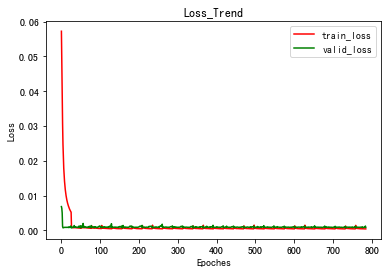

In [11]:
net = LSTM(vehicle_feature.shape[1],2,256,2)

if train_on_gpu:
    net.cuda()
from time import time
start = time()
epochs = 30
train(net,epochs,train_loader,valid_loader,clip=5,print_every=100,lr=0.0001)
print('Training time is',time()-start,'s')

Test loss: 0.001
Test Loss: 0.00044508263817988336
actuale_angle_0:2.6513801934647825,prdict_angle_0:1.552329393293563
actuale_angle_1:2.793040817392128,prdict_angle_1:2.9156981200771717
actuale_angle_2:2.8365866800878794,prdict_angle_2:-2.9816445672192673
actuale_angle_3:2.723297088450213,prdict_angle_3:-2.88017962225171
actuale_angle_4:2.761172775787916,prdict_angle_4:-1.7583155197934426
actuale_angle_5:2.686957844105028,prdict_angle_5:2.1493001032263375
actuale_angle_6:2.66373398961515,prdict_angle_6:2.7897076151406965
actuale_angle_7:2.6730776120761006,prdict_angle_7:-2.7746897483599504
actuale_angle_8:2.6700625053967206,prdict_angle_8:2.9512238976161957
actuale_angle_9:2.657600819194768,prdict_angle_9:2.841762109675997
actuale_angle_10:2.6733031902110245,prdict_angle_10:2.719975294202006
actuale_angle_11:2.7309549191126465,prdict_angle_11:2.9839164426376836
actuale_angle_12:2.779817636093836,prdict_angle_12:2.987784706512234
actuale_angle_13:2.805601906593334,prdict_angle_13:2.343

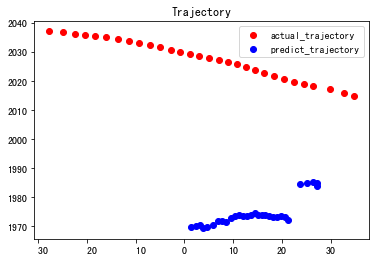

Test Loss: 0.0005760084750363603
actuale_angle_0:-1.4735427138815567,prdict_angle_0:-1.5383348191459099
actuale_angle_1:-1.474492262589421,prdict_angle_1:-1.5379012471724196
actuale_angle_2:-1.4735427138815684,prdict_angle_2:-1.5383052895690537
actuale_angle_3:-1.4745937280161328,prdict_angle_3:-1.5379134386630184
actuale_angle_4:-1.4735446176985232,prdict_angle_4:-1.538360231818308
actuale_angle_5:-1.4745937280161345,prdict_angle_5:-1.5379257021547752
actuale_angle_6:-1.473440153904065,prdict_angle_6:-1.5383694045645822
actuale_angle_7:-1.474593728016123,prdict_angle_7:-1.5378952675675976
actuale_angle_8:-1.477598935115414,prdict_angle_8:-1.5383811848821816
actuale_angle_9:-1.461741851698943,prdict_angle_9:-1.5799409776555704
actuale_angle_10:-1.4280330998251214,prdict_angle_10:-1.5484960926443754
actuale_angle_11:-1.3712644134323233,prdict_angle_11:-1.4944043115368102
actuale_angle_12:-1.6109461651689831,prdict_angle_12:-1.471951165057574
actuale_angle_13:-1.5906414366251513,prdict_a

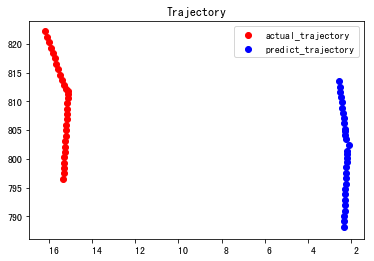

Test Loss: 0.0009278852279142787
actuale_angle_0:0.0,prdict_angle_0:0.0
actuale_angle_1:0.0,prdict_angle_1:0.0
actuale_angle_2:0.0,prdict_angle_2:0.0
actuale_angle_3:0.0,prdict_angle_3:0.0
actuale_angle_4:0.0,prdict_angle_4:0.0
actuale_angle_5:0.0,prdict_angle_5:0.0
actuale_angle_6:0.0,prdict_angle_6:0.0
actuale_angle_7:0.0,prdict_angle_7:0.0
actuale_angle_8:0.0,prdict_angle_8:0.0
actuale_angle_9:0.0,prdict_angle_9:0.0
actuale_angle_10:0.0,prdict_angle_10:0.0
actuale_angle_11:0.0,prdict_angle_11:0.0
actuale_angle_12:0.0,prdict_angle_12:0.0
actuale_angle_13:0.0,prdict_angle_13:0.0
actuale_angle_14:0.0,prdict_angle_14:0.0
actuale_angle_15:0.0,prdict_angle_15:0.0
actuale_angle_16:0.0,prdict_angle_16:0.0
actuale_angle_17:0.0,prdict_angle_17:0.0
actuale_angle_18:0.0,prdict_angle_18:0.0
actuale_angle_19:0.0,prdict_angle_19:0.0
actuale_angle_20:0.0,prdict_angle_20:0.0
actuale_angle_21:0.0,prdict_angle_21:0.0
actuale_angle_22:0.0,prdict_angle_22:0.0
actuale_angle_23:0.0,prdict_angle_23:0.0
act

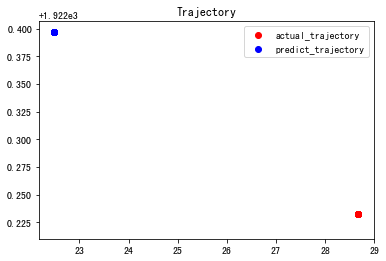

Test Loss: 0.0009548947055009194
actuale_angle_0:2.283180892358394,prdict_angle_0:1.675823941044965
actuale_angle_1:1.4160780064429115,prdict_angle_1:-1.035222875635703
actuale_angle_2:1.0547048537908261,prdict_angle_2:1.8058910799304828
actuale_angle_3:0.12266913341101164,prdict_angle_3:1.5664890442398103
actuale_angle_4:-0.6369833094519128,prdict_angle_4:0.6094876697023351
actuale_angle_5:-1.496105941227737,prdict_angle_5:-1.3289816736497693
actuale_angle_6:-1.769092658544223,prdict_angle_6:-1.5516389518779008
actuale_angle_7:-2.399044726705906,prdict_angle_7:-1.9490195981243248
actuale_angle_8:-2.6618394587735397,prdict_angle_8:-2.4167140065566755
actuale_angle_9:-2.7907909372569217,prdict_angle_9:-1.749961756212702
actuale_angle_10:-0.942474471493067,prdict_angle_10:-1.1545426592361088
actuale_angle_11:-1.2338219410256792,prdict_angle_11:1.2546929533167694
actuale_angle_12:-1.8357090588474285,prdict_angle_12:-1.5618535271375693
actuale_angle_13:-2.494128622828284,prdict_angle_13:-2

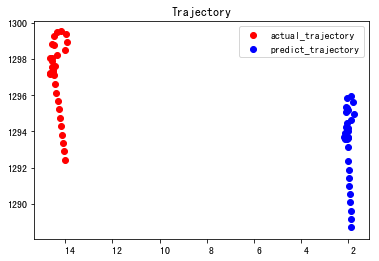

Test Loss: 0.0014191967027727514
actuale_angle_0:2.7892316996276914,prdict_angle_0:-2.9296462565414734
actuale_angle_1:2.7914958390934816,prdict_angle_1:-2.877246286036407
actuale_angle_2:2.8014663544916574,prdict_angle_2:-3.0035654280976143
actuale_angle_3:2.782916378255573,prdict_angle_3:2.836636230648995
actuale_angle_4:2.7747308547362106,prdict_angle_4:2.8401402893182977
actuale_angle_5:2.7378441378999874,prdict_angle_5:-2.734955713099853
actuale_angle_6:2.7400457772840126,prdict_angle_6:-2.393277951312414
actuale_angle_7:2.7572434802040875,prdict_angle_7:-2.2243779676930426
actuale_angle_8:2.7931470869462554,prdict_angle_8:-2.736563497058632
actuale_angle_9:2.840467251062483,prdict_angle_9:3.0931158301082537
actuale_angle_10:2.9116930443374116,prdict_angle_10:-3.1163717927063375
actuale_angle_11:2.96344078582645,prdict_angle_11:-2.950265618230499
actuale_angle_12:2.980119477393514,prdict_angle_12:-2.7866284428860584
actuale_angle_13:2.9771453317986087,prdict_angle_13:-2.6390972979

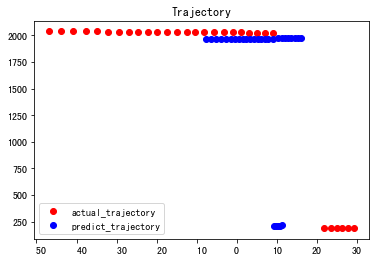

Test Loss: 0.0013575982350933675
actuale_angle_0:-1.5698037791023465,prdict_angle_0:-1.5373241440228171
actuale_angle_1:-1.5701373569842365,prdict_angle_1:-1.5293902752983706
actuale_angle_2:-1.5707963267948966,prdict_angle_2:-1.5448156923792307
actuale_angle_3:-1.5686756507116975,prdict_angle_3:-1.574154287834003
actuale_angle_4:-1.5739783113466899,prdict_angle_4:-1.5751216130849142
actuale_angle_5:-1.565930833515654,prdict_angle_5:-1.5842828000676525
actuale_angle_6:-1.5487349289744565,prdict_angle_6:-1.578162806895343
actuale_angle_7:-1.5429866307230293,prdict_angle_7:-1.5679875897029343
actuale_angle_8:-1.5500868458422299,prdict_angle_8:-1.5758364357058616
actuale_angle_9:-1.5279735595170325,prdict_angle_9:-1.5941854645655393
actuale_angle_10:-1.5744882360483585,prdict_angle_10:-1.5780075018257913
actuale_angle_11:-1.6117361413974352,prdict_angle_11:-1.5110685362580045
actuale_angle_12:-1.6454798958457015,prdict_angle_12:-1.5957907971073078
actuale_angle_13:-1.6041174541681023,prdi

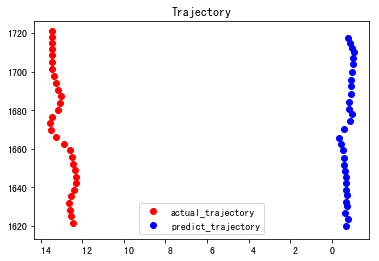

Test Loss: 0.0013989364836431508
actuale_angle_0:1.611340411429508,prdict_angle_0:1.5801757610660958
actuale_angle_1:1.6111858130212369,prdict_angle_1:1.580172779933761
actuale_angle_2:1.6130465574600457,prdict_angle_2:1.591433474898843
actuale_angle_3:1.6122432093307741,prdict_angle_3:1.5917608410080764
actuale_angle_4:1.6039205097821954,prdict_angle_4:1.5730558622220832
actuale_angle_5:1.593519792379635,prdict_angle_5:1.572007476213997
actuale_angle_6:1.5846363306076292,prdict_angle_6:1.546556718764574
actuale_angle_7:1.5871754993038463,prdict_angle_7:1.5768254362105538
actuale_angle_8:1.5953975977277364,prdict_angle_8:1.583767367918436
actuale_angle_9:1.573105736201589,prdict_angle_9:1.5944085394593213
actuale_angle_10:1.5377784583761207,prdict_angle_10:1.5199631159862557
actuale_angle_11:1.512880411841557,prdict_angle_11:1.544859924988427
actuale_angle_12:1.4744217765031298,prdict_angle_12:1.5418189841824472
actuale_angle_13:1.4888590559936947,prdict_angle_13:1.5334847267208076
act

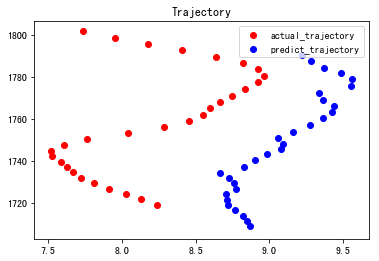

Test Loss: 0.0016702474422345404
actuale_angle_0:2.1705581390765794,prdict_angle_0:1.7923589523113097
actuale_angle_1:2.0970242361945792,prdict_angle_1:1.7388468074057344
actuale_angle_2:2.142563820580061,prdict_angle_2:1.6312396155521383
actuale_angle_3:2.137939826439909,prdict_angle_3:1.635270962076214
actuale_angle_4:2.1355314300327874,prdict_angle_4:1.7296167899936634
actuale_angle_5:2.138395477173884,prdict_angle_5:1.8582107272946737
actuale_angle_6:2.140637006275519,prdict_angle_6:1.8028124655935505
actuale_angle_7:2.1410678671596113,prdict_angle_7:1.8055262696762917
actuale_angle_8:2.1433421921795524,prdict_angle_8:1.8067514005781866
actuale_angle_9:2.1443794844054747,prdict_angle_9:1.8058579482884243
actuale_angle_10:2.1451896244935016,prdict_angle_10:1.8069047318005542
actuale_angle_11:2.146604066784933,prdict_angle_11:1.81391615284367
actuale_angle_12:2.1490756153209367,prdict_angle_12:1.812518173947415
actuale_angle_13:2.132748016427827,prdict_angle_13:1.721931585125175
actu

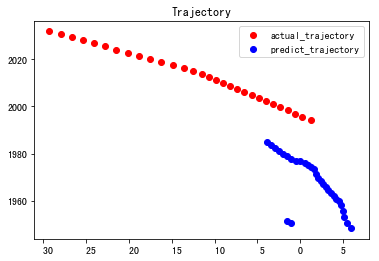

Test Loss: 0.0014877575027235758
actuale_angle_0:-1.6368158375892892,prdict_angle_0:-1.6007094849411947
actuale_angle_1:-1.6347584696825463,prdict_angle_1:-1.6013065628154186
actuale_angle_2:-1.6357203609510538,prdict_angle_2:-1.6007479285915653
actuale_angle_3:-1.6357203609510538,prdict_angle_3:-1.6005731739102953
actuale_angle_4:-1.6355875138074565,prdict_angle_4:-1.6007346102319053
actuale_angle_5:-1.6355205980307994,prdict_angle_5:-1.6025636240660748
actuale_angle_6:-1.6370888947090232,prdict_angle_6:-1.6058797039230517
actuale_angle_7:-1.6342032996363598,prdict_angle_7:-1.6076534348627585
actuale_angle_8:-1.6316569629570015,prdict_angle_8:-1.600967806537139
actuale_angle_9:-1.6296175664481296,prdict_angle_9:-1.5914066577914399
actuale_angle_10:-1.627359343321943,prdict_angle_10:-1.5879704018857022
actuale_angle_11:-1.633510421624696,prdict_angle_11:-1.7126198108432171
actuale_angle_12:-1.6485803443539273,prdict_angle_12:-1.7445259018731645
actuale_angle_13:-1.7327321750714015,prdi

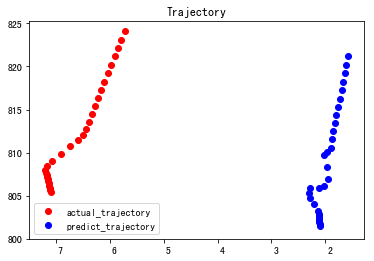

Test Loss: 0.0013392998210747463
actuale_angle_0:-1.5519168492744821,prdict_angle_0:1.6777868301611212
actuale_angle_1:1.736418077308526,prdict_angle_1:-1.4850033096426343
actuale_angle_2:1.5707963267948966,prdict_angle_2:-1.4858505875671089
actuale_angle_3:1.5707963267948966,prdict_angle_3:-1.4957357683812234
actuale_angle_4:-1.5707963267948966,prdict_angle_4:-0.1733942145749277
actuale_angle_5:0.0,prdict_angle_5:-1.510107235269334
actuale_angle_6:0.0,prdict_angle_6:0.0
actuale_angle_7:0.0,prdict_angle_7:0.0
actuale_angle_8:0.0,prdict_angle_8:0.0
actuale_angle_9:0.0,prdict_angle_9:0.0
actuale_angle_10:0.0,prdict_angle_10:0.0
actuale_angle_11:0.0,prdict_angle_11:0.0
actuale_angle_12:0.0,prdict_angle_12:0.0
actuale_angle_13:0.0,prdict_angle_13:0.0
actuale_angle_14:0.0,prdict_angle_14:0.0
actuale_angle_15:0.0,prdict_angle_15:0.0
actuale_angle_16:0.0,prdict_angle_16:0.0
actuale_angle_17:0.0,prdict_angle_17:0.0
actuale_angle_18:0.0,prdict_angle_18:0.0
actuale_angle_19:0.0,prdict_angle_19:0

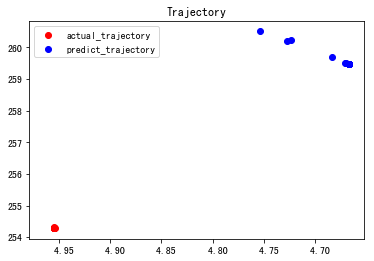

Test Loss: 0.0012589501155740766
actuale_angle_0:0.0,prdict_angle_0:0.0
actuale_angle_1:0.0,prdict_angle_1:0.0
actuale_angle_2:0.0,prdict_angle_2:0.0
actuale_angle_3:-1.5707963267948966,prdict_angle_3:0.0
actuale_angle_4:1.5707963267948966,prdict_angle_4:-1.5117069776399792
actuale_angle_5:1.5707963267948966,prdict_angle_5:1.6467279177382235
actuale_angle_6:2.1366834004149773,prdict_angle_6:-1.509968668431787
actuale_angle_7:-1.5199984623510054,prdict_angle_7:-1.547555143960173
actuale_angle_8:-1.4025649315671744,prdict_angle_8:-1.5979883863687148
actuale_angle_9:-1.3511683908018743,prdict_angle_9:2.1358489412160977
actuale_angle_10:-1.3510394646452393,prdict_angle_10:-1.6014675850626727
actuale_angle_11:-1.3650212776686614,prdict_angle_11:1.540414379550063
actuale_angle_12:-1.3765030887798326,prdict_angle_12:1.5746681661949278
actuale_angle_13:-1.3741138693492756,prdict_angle_13:-1.5025647175875205
actuale_angle_14:-1.3701845340093717,prdict_angle_14:-1.5001432414760618
actuale_angle_

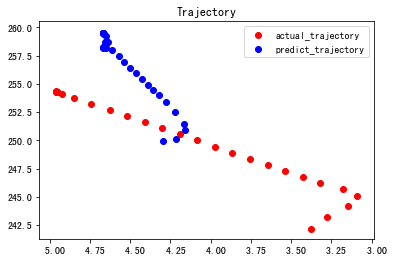

Test Loss: 0.001326743131320048
actuale_angle_0:-1.5565770782719268,prdict_angle_0:-1.5208027593697768
actuale_angle_1:-1.593211646690128,prdict_angle_1:-1.5691646485622175
actuale_angle_2:-1.6229299727040616,prdict_angle_2:-1.5846034914165388
actuale_angle_3:-1.641737244492666,prdict_angle_3:-1.5788983472346836
actuale_angle_4:-1.6370386467848974,prdict_angle_4:-1.5920077645683988
actuale_angle_5:-1.6432607619815154,prdict_angle_5:-1.5986830988824412
actuale_angle_6:-1.6871553547669094,prdict_angle_6:-1.693039914835348
actuale_angle_7:-1.6977511753365608,prdict_angle_7:-1.6234927414814695
actuale_angle_8:-1.6405967462187567,prdict_angle_8:-1.6243573212737004
actuale_angle_9:-1.5879372429213694,prdict_angle_9:-1.601805642179514
actuale_angle_10:-1.5548253120040951,prdict_angle_10:-1.5835956926355779
actuale_angle_11:-1.5733656374333587,prdict_angle_11:-1.5571316135849795
actuale_angle_12:-1.6030520461572586,prdict_angle_12:-1.5742140619763554
actuale_angle_13:-1.6331618236763759,prdict

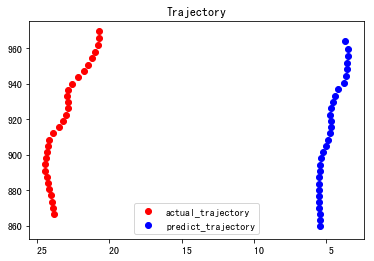

Test Loss: 0.0012608531474842704
actuale_angle_0:-0.45734657881070534,prdict_angle_0:-1.016889935858326
actuale_angle_1:-0.6093411274288606,prdict_angle_1:-1.0631974041987025
actuale_angle_2:-0.7765259750633857,prdict_angle_2:-1.1953897142642997
actuale_angle_3:-0.9116393563183095,prdict_angle_3:-1.2626556080429192
actuale_angle_4:-0.9695178190953229,prdict_angle_4:-0.31822008805230145
actuale_angle_5:-0.9798135027783823,prdict_angle_5:1.4766679537134029
actuale_angle_6:-0.9902142446462232,prdict_angle_6:-1.2393712039436067
actuale_angle_7:-1.0080374326316894,prdict_angle_7:-1.2615159169788512
actuale_angle_8:-1.0259523329737552,prdict_angle_8:-1.2731717572602341
actuale_angle_9:-1.041467766806604,prdict_angle_9:-1.2870972918448988
actuale_angle_10:-1.056508806697963,prdict_angle_10:-1.2971599180887134
actuale_angle_11:-1.0664089414969729,prdict_angle_11:-1.2841691721077915
actuale_angle_12:-1.070343722477817,prdict_angle_12:1.3982511532234416
actuale_angle_13:-1.0851158793730016,prdic

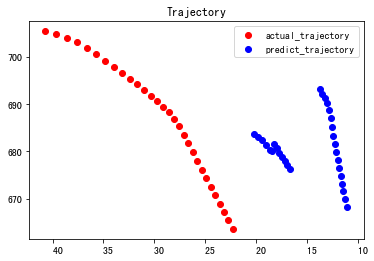

Test Loss: 0.0011979344656083413
actuale_angle_0:0.0,prdict_angle_0:0.0
actuale_angle_1:0.0,prdict_angle_1:0.0
actuale_angle_2:0.0,prdict_angle_2:0.0
actuale_angle_3:0.0,prdict_angle_3:0.0
actuale_angle_4:0.0,prdict_angle_4:0.0
actuale_angle_5:0.0,prdict_angle_5:0.0
actuale_angle_6:0.0,prdict_angle_6:0.0
actuale_angle_7:0.0,prdict_angle_7:0.0
actuale_angle_8:0.0,prdict_angle_8:0.0
actuale_angle_9:0.0,prdict_angle_9:0.0
actuale_angle_10:0.0,prdict_angle_10:0.0
actuale_angle_11:0.0,prdict_angle_11:0.0
actuale_angle_12:0.0,prdict_angle_12:0.0
actuale_angle_13:0.0,prdict_angle_13:0.0
actuale_angle_14:0.0,prdict_angle_14:0.0
actuale_angle_15:0.0,prdict_angle_15:0.0
actuale_angle_16:0.0,prdict_angle_16:0.0
actuale_angle_17:0.0,prdict_angle_17:0.0
actuale_angle_18:0.0,prdict_angle_18:0.0
actuale_angle_19:0.0,prdict_angle_19:0.0
actuale_angle_20:0.0,prdict_angle_20:0.0
actuale_angle_21:0.0,prdict_angle_21:0.0
actuale_angle_22:0.0,prdict_angle_22:0.0
actuale_angle_23:0.0,prdict_angle_23:0.0
act

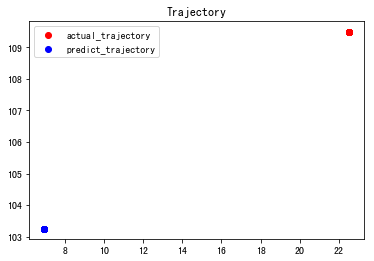

Test Loss: 0.001135064953480954
actuale_angle_0:1.4503788239078839,prdict_angle_0:1.4328830103751546
actuale_angle_1:1.4453782224327816,prdict_angle_1:1.533248608120268
actuale_angle_2:1.4609464896049904,prdict_angle_2:1.534953792885292
actuale_angle_3:1.4588563114795565,prdict_angle_3:1.553203474843307
actuale_angle_4:1.4505496339357553,prdict_angle_4:1.5220107483902148
actuale_angle_5:1.4456203146038185,prdict_angle_5:1.5314231907800755
actuale_angle_6:1.4753811209856782,prdict_angle_6:1.5324423643168987
actuale_angle_7:1.4984547571805713,prdict_angle_7:1.5256712466406122
actuale_angle_8:1.5212914379210967,prdict_angle_8:1.534904989677517
actuale_angle_9:1.5563650761601733,prdict_angle_9:1.547906902790406
actuale_angle_10:1.553023323117354,prdict_angle_10:1.5421095126755968
actuale_angle_11:1.5366960476142062,prdict_angle_11:1.530025491834223
actuale_angle_12:1.5285818176485821,prdict_angle_12:1.525838675008259
actuale_angle_13:1.5294176180668568,prdict_angle_13:1.5498340434095836
ac

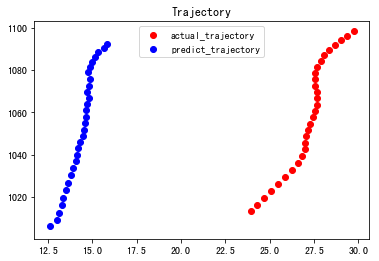

Test Loss: 0.001155682960387594
actuale_angle_0:1.4650597392728886,prdict_angle_0:1.5291680456229981
actuale_angle_1:1.4902126144963763,prdict_angle_1:1.5368662745900623
actuale_angle_2:1.5086985159531887,prdict_angle_2:1.58032839703465
actuale_angle_3:1.521665132319668,prdict_angle_3:1.5366204926621532
actuale_angle_4:1.5088380656496072,prdict_angle_4:1.5259422803016591
actuale_angle_5:1.4911878878388696,prdict_angle_5:1.4811508989573918
actuale_angle_6:1.4934791792824487,prdict_angle_6:1.5236377273771962
actuale_angle_7:1.5202260460082746,prdict_angle_7:1.5451890232934422
actuale_angle_8:1.5359885127751882,prdict_angle_8:1.5516844239526608
actuale_angle_9:1.5556765005022972,prdict_angle_9:1.583493828386892
actuale_angle_10:1.5593094784487376,prdict_angle_10:1.5719283656245344
actuale_angle_11:1.5653183424416233,prdict_angle_11:1.5454382197060434
actuale_angle_12:1.5800939144162138,prdict_angle_12:1.517875307243231
actuale_angle_13:1.5888995189030268,prdict_angle_13:-0.270582612467784

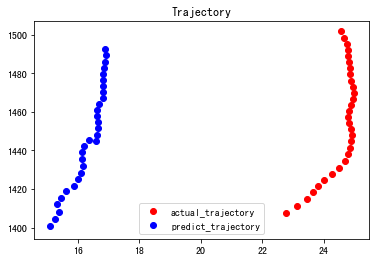

Test Loss: 0.0011070000207783939
actuale_angle_0:1.6204469476058943,prdict_angle_0:1.791232909189196
actuale_angle_1:1.6299732346831983,prdict_angle_1:1.6608902274323323
actuale_angle_2:1.631107212342765,prdict_angle_2:1.6525950967936964
actuale_angle_3:1.6327472061888342,prdict_angle_3:1.6411781748631735
actuale_angle_4:1.6338064708946016,prdict_angle_4:1.6278502439955582
actuale_angle_5:1.630373403621074,prdict_angle_5:1.6148772519658092
actuale_angle_6:1.6305123021032606,prdict_angle_6:1.6193075436796267
actuale_angle_7:1.6308254562359015,prdict_angle_7:1.5998872473050307
actuale_angle_8:1.6313297176383992,prdict_angle_8:1.578067866193068
actuale_angle_9:1.6306064856798541,prdict_angle_9:1.5857895533075723
actuale_angle_10:1.6306104997224968,prdict_angle_10:1.5855311207550074
actuale_angle_11:1.6306077886085308,prdict_angle_11:1.5855304049223171
actuale_angle_12:1.6306539109559806,prdict_angle_12:1.5855385675737064
actuale_angle_13:1.6306511959100969,prdict_angle_13:1.58531221251552

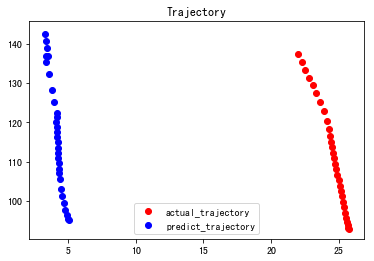

Test Loss: 0.0011025175537674335
actuale_angle_0:0.0,prdict_angle_0:0.0
actuale_angle_1:0.0,prdict_angle_1:0.0
actuale_angle_2:0.0,prdict_angle_2:0.0
actuale_angle_3:0.0,prdict_angle_3:0.0
actuale_angle_4:0.0,prdict_angle_4:0.0
actuale_angle_5:0.0,prdict_angle_5:0.0
actuale_angle_6:0.0,prdict_angle_6:0.0
actuale_angle_7:0.0,prdict_angle_7:0.0
actuale_angle_8:0.0,prdict_angle_8:0.0
actuale_angle_9:0.0,prdict_angle_9:0.0
actuale_angle_10:0.0,prdict_angle_10:0.0
actuale_angle_11:0.0,prdict_angle_11:1.5677202800545837
actuale_angle_12:0.0,prdict_angle_12:-1.5738723735352094
actuale_angle_13:0.0,prdict_angle_13:0.0
actuale_angle_14:0.0,prdict_angle_14:0.0
actuale_angle_15:0.0,prdict_angle_15:0.0
actuale_angle_16:0.0,prdict_angle_16:1.5677202800545837
actuale_angle_17:0.0,prdict_angle_17:0.0
actuale_angle_18:0.0,prdict_angle_18:0.0
actuale_angle_19:0.0,prdict_angle_19:0.0
actuale_angle_20:0.0,prdict_angle_20:0.0
actuale_angle_21:0.0,prdict_angle_21:0.0
actuale_angle_22:0.0,prdict_angle_22:0.

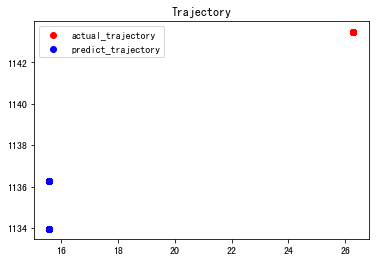

Test Loss: 0.001052441530359111
actuale_angle_0:0.0,prdict_angle_0:0.0
actuale_angle_1:0.0,prdict_angle_1:0.0
actuale_angle_2:0.0,prdict_angle_2:0.0
actuale_angle_3:0.0,prdict_angle_3:0.0
actuale_angle_4:0.0,prdict_angle_4:0.0
actuale_angle_5:0.0,prdict_angle_5:0.0
actuale_angle_6:0.0,prdict_angle_6:0.0
actuale_angle_7:0.0,prdict_angle_7:0.0
actuale_angle_8:0.0,prdict_angle_8:0.0
actuale_angle_9:0.0,prdict_angle_9:0.0
actuale_angle_10:0.0,prdict_angle_10:0.0
actuale_angle_11:0.0,prdict_angle_11:0.0
actuale_angle_12:0.0,prdict_angle_12:0.0
actuale_angle_13:0.0,prdict_angle_13:0.0
actuale_angle_14:0.0,prdict_angle_14:0.0
actuale_angle_15:0.0,prdict_angle_15:0.0
actuale_angle_16:0.0,prdict_angle_16:0.0
actuale_angle_17:0.0,prdict_angle_17:0.0
actuale_angle_18:0.0,prdict_angle_18:0.0
actuale_angle_19:0.0,prdict_angle_19:0.0
actuale_angle_20:0.0,prdict_angle_20:0.0
actuale_angle_21:0.0,prdict_angle_21:0.0
actuale_angle_22:0.0,prdict_angle_22:0.0
actuale_angle_23:0.0,prdict_angle_23:0.0
actu

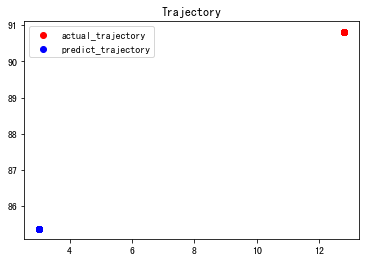

Test Loss: 0.001033870641526846
actuale_angle_0:1.5083613687005029,prdict_angle_0:1.5507722329725628
actuale_angle_1:1.4644814567585969,prdict_angle_1:1.5518183951091844
actuale_angle_2:1.4223244174727026,prdict_angle_2:1.541339652041612
actuale_angle_3:1.3796822917823266,prdict_angle_3:1.5213435551263876
actuale_angle_4:1.4179564340197208,prdict_angle_4:1.4922347208769735
actuale_angle_5:1.472445035605721,prdict_angle_5:1.53110512001484
actuale_angle_6:1.527156137862572,prdict_angle_6:1.5409628935578148
actuale_angle_7:1.574978399795966,prdict_angle_7:0.1778033674909963
actuale_angle_8:1.6315263391529478,prdict_angle_8:1.5411907894240744
actuale_angle_9:1.6018486932391522,prdict_angle_9:1.5856692526939085
actuale_angle_10:1.5667176155320512,prdict_angle_10:1.4878702384569582
actuale_angle_11:1.5183717098999518,prdict_angle_11:1.5650263642051154
actuale_angle_12:1.4662834606493584,prdict_angle_12:1.5523314433933078
actuale_angle_13:1.424431225291176,prdict_angle_13:1.5359034396981837
a

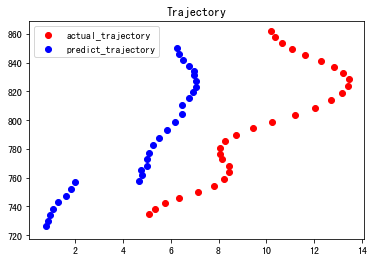

In [12]:
net_test = LSTM(vehicle_feature.shape[1],2,256,2)
if train_on_gpu:
    net_test.cuda() 
net_test.load_state_dict(torch.load('model/lstm_trajectory_prediction_new.pt'))
test(net_test,train_loader)
actual_angles,predict_angles = predict(net_test,train_loader)

In [71]:
print(len(actual_angles)/29)
for i in actual_angles:
    print(i)

20.0
2.6513801934647825
2.793040817392128
2.8365866800878794
2.723297088450213
2.761172775787916
2.686957844105028
2.66373398961515
2.6730776120761006
2.6700625053967206
2.657600819194768
2.6733031902110245
2.7309549191126465
2.779817636093836
2.805601906593334
2.801226048490838
2.7978623122621187
2.7841800477294565
2.771260003168661
2.780490449501412
2.7975743472554737
2.825477961893506
2.853315817031879
2.868158269999868
2.891728413800193
2.919366695990667
2.93681842622286
2.956436241497202
2.9845418287313543
2.996891426681766
-1.4735427138815567
-1.474492262589421
-1.4735427138815684
-1.4745937280161328
-1.4735446176985232
-1.4745937280161345
-1.473440153904065
-1.474593728016123
-1.477598935115414
-1.461741851698943
-1.4280330998251214
-1.3712644134323233
-1.6109461651689831
-1.5906414366251513
-1.5873419997102955
-1.5838874654854982
-1.5855795245811193
-1.58452330960599
-1.5855774883311338
-1.5845233096059885
-1.5855795245811193
-1.584494392502828
-1.584552349049778
-1.58570348673

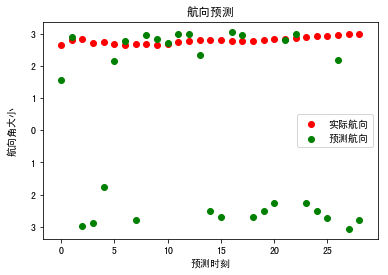

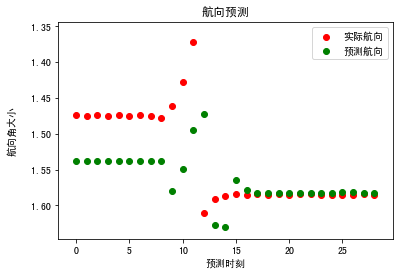

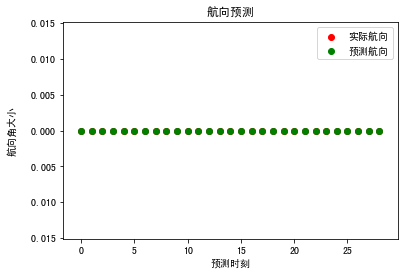

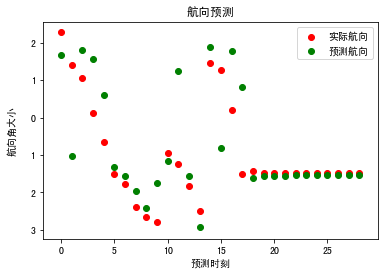

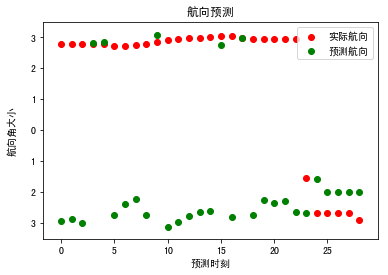

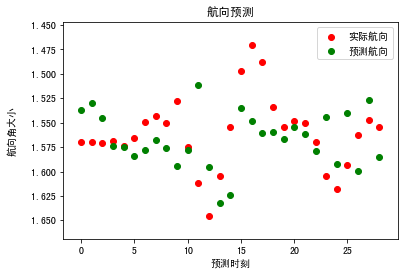

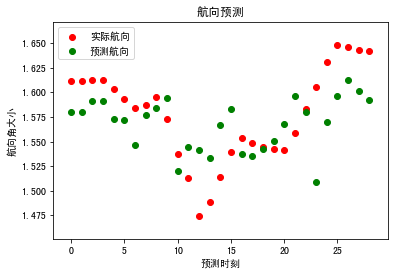

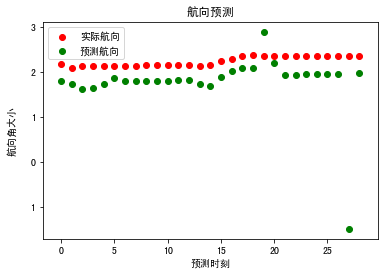

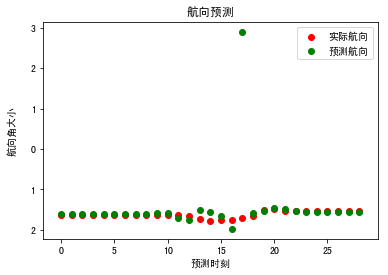

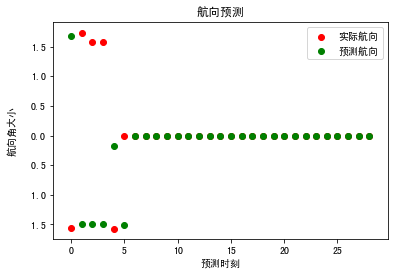

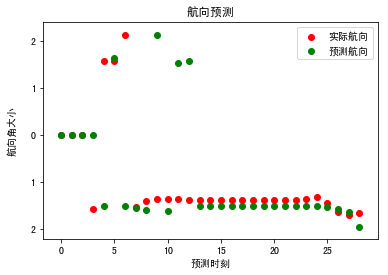

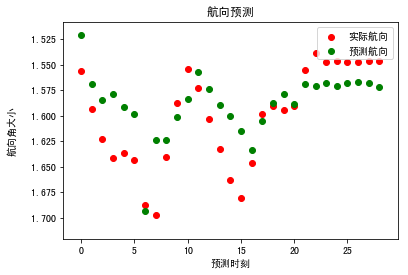

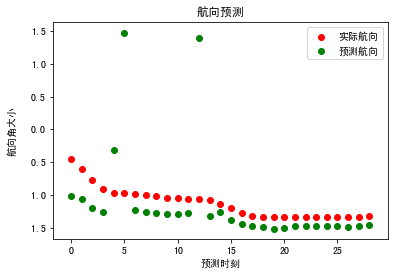

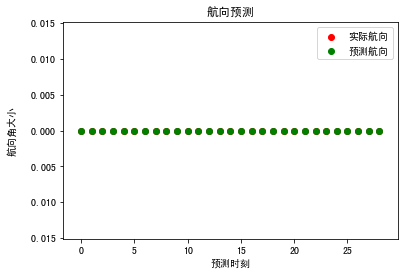

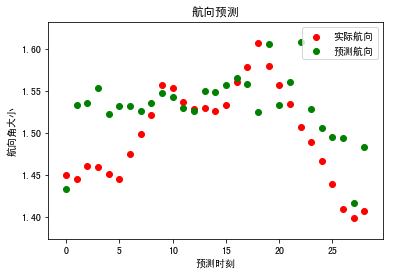

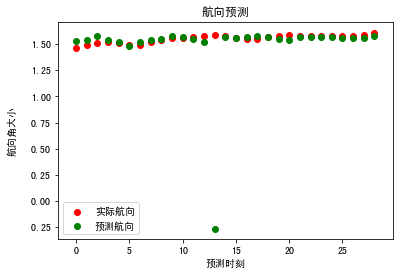

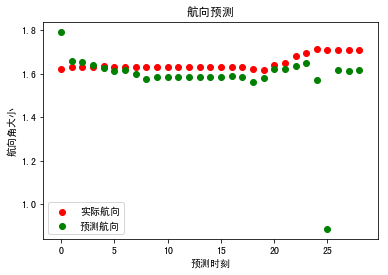

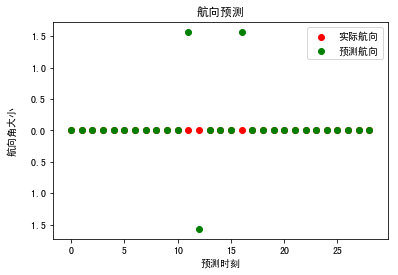

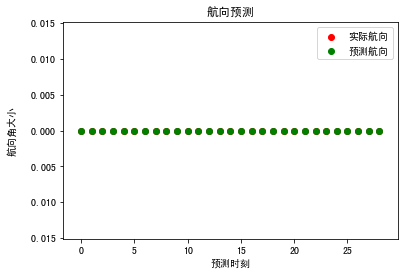

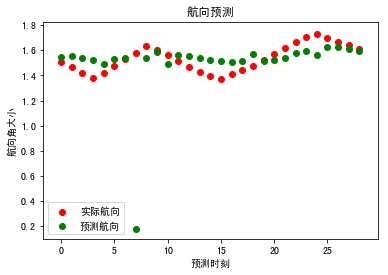

In [13]:
i_= 0
for i in range(0,len(actual_angles),29):
    plt.scatter([range(len(actual_angles[i:i+29]))],actual_angles[i:i+29],color='r',label='实际航向')
    plt.scatter([range(len(predict_angles[i:i+29]))],predict_angles[i:i+29],color='g',label='预测航向')
    #plt.title('Loss_Trend')
    #plt.xlabel('Epoches')
    #plt.ylabel('Loss')
    plt.title('航向预测')
    plt.xlabel('预测时刻')
    plt.ylabel('航向角大小')
    plt.legend()
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.savefig('trajectory_image/航向_new/svg/航向_new_{}.svg'.format(i_),dpi=300)
    plt.savefig('trajectory_image/航向_new/png/航向_new_{}.png'.format(i_),dpi=300)
    i_ += 1
    plt.show()